# FEgrow - congeneric ligands from a template

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

## Overview

This notebook demonstrates the entire rgroups workflow for generating a series of ligands with a common core for a specific binding site, by the addition of a user-defined set of R-groups. 

These de novo ligands are then subjected to ADMET analysis. Valid conformers are enumerated, and optimised in the receptor using hybrid machine learning / molecular mechanics potentials (ML/MM). 

An ensemble of low energy conformers is generated for each ligand, and scored using a convolutional neural network (CNN), then finally compared to experimental data (where available).

The target for this tutorial is PTP1B. [1][2]

In [1]:
import copy

import prody
from rdkit import Chem

import fegrow
from fegrow import RGroups

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
RDKit WARNING: [12:25:37] Warning: molecule is tagged as 3D, but all Z coords are zero


# Prepare the ligand template

Protonate the template structure with open babel

In [2]:
!obabel sarscov2/lig.pdb -O sarscov2/coreh.sdf -p 7

1 molecule converted


Load the protonated ligand into FEgrow

In [3]:
init_mol = Chem.SDMolSupplier('sarscov2/coreh.sdf', removeHs=False)[0]

# get the FEgrow representation of the rdkit Mol
template_mol = fegrow.RMol(init_mol)

Show the 2D (with indices) representation of the core. This is used to select the desired growth vector.

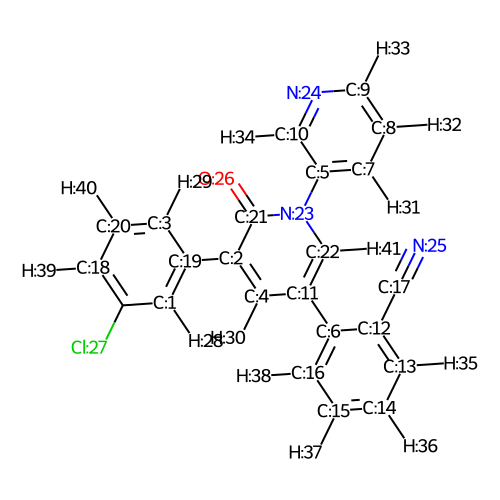

In [4]:
template_mol.rep2D(idx=True, size=(500, 500))

Using the 2D drawing, select a hydrogen index for the R-group

In [5]:
attachment_index = [40]

R-groups can be selected interactively or programmaticaly. Tailor .mol files can be used as well as long as their hydrogen is replaced with the *element* R. 

In [6]:
# interactive selection
RGroups

In [7]:
# retrieve the interactively selected groups
interactive_rgroups = RGroups.get_selected()

# you can also directly access the built-in dataframe programmatically
groups = RGroups.dataframe
R_group_ethanol = groups.loc[groups['Name']=='ethanol']['Mol'].values[0]
R_group_cyclopropane = groups.loc[groups['Name'] == 'cyclopropane' ]['Mol'].values[0]

# add your own R-groups files
R_group_methanol = Chem.MolFromMolFile('manual_rgroups/methanol-r.mol', removeHs=False)

# make a list of R-group molecule
selected_rgroups = [R_group_methanol, R_group_ethanol, R_group_cyclopropane] + interactive_rgroups
selected_rgroups

# Build a congeneric series

Merge the template with the R-groups

In [8]:
rmols = fegrow.build_molecules(template_mol, 
                               attachment_index, 
                               selected_rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fdea6cc2220> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fdea6cc2340>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fdea6cc2280> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fdea6cc24c0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fdea6cc2340> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fdea6cc2220>


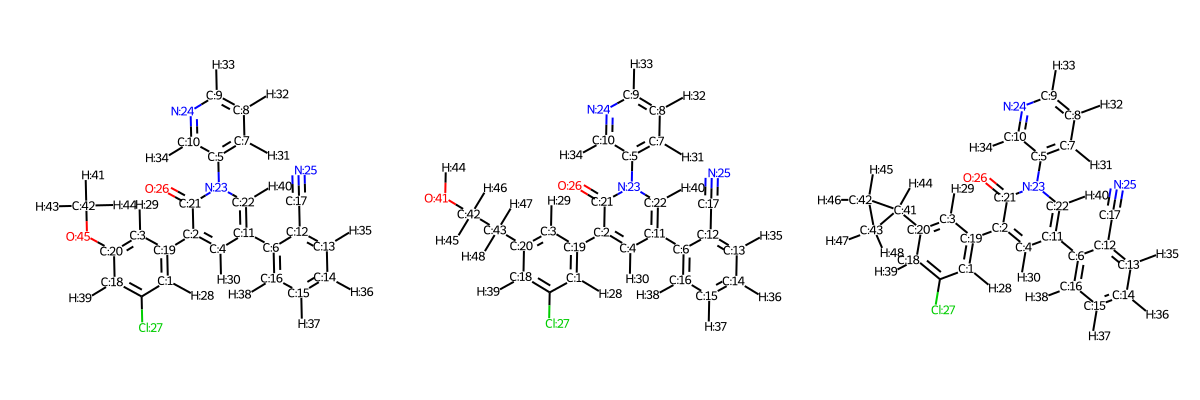

In [9]:
rmols.rep2D()

In [10]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Once the ligands have been generated, they can be assessed for various ADMET properties, including Lipinksi rule of 5 properties, the presence of unwanted substructures or problematic functional groups, and synthetic accessibility. [3][4]

In [11]:
rmols.toxicity()

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility
0,413.093104,5,0,5.10018,True,False,False,True,7.318364
0,427.108754,5,1,4.62638,True,False,False,True,7.598183
0,423.113840,4,0,5.96898,True,False,False,True,7.574687


For each ligand, a specified number of conformers (`num_conf`) is generated by using the RDKit ETKDG algorithm.[5] Conformers that are too similar to the initial structure are discarded. Empirically, we have found that `num_conf=200` gives an exhaustive search, and `num_conf=50` gives a reasonable, fast search, in most cases.

If required, a third argument can be added `flexible=[0,1,...]`, which provides a list of additional atoms in the core that can be allowed to be flexible. This is useful, for example, if growing from a methyl group and you would like the added R-group to freely rotate.

In [12]:
rmols.generate_conformers(num_conf=10, 
                         minimum_conf_rms=0.5, 
                        )
                        # flexible=[39, 18, 40, 16, 17, 19, 5, 6, 36, 2, 1, 33, 3, 4, 35, 34, 15, 38])

RMol index 0
Removed 8 duplicated conformations, leaving 3 in total. 
RMol index 1
Removed 4 duplicated conformations, leaving 7 in total. 
RMol index 2
Removed 5 duplicated conformations, leaving 6 in total. 


In [13]:
#rmol.rep3D(template=True)

### Prepare the protein

The protein structure initially is not protonated, this along with other repairs is done using PDBFixer [6]. 

In [14]:
# load the complex with the ligand
sys = prody.parsePDB('sarscov2/7l10.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
rec_final = prody.parsePDB("rec_final.pdb")

@> 2609 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4638 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [15]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Any conformers that clash with the protein (within 1 A of the backbone), are removed.

In [16]:
rmols.remove_clashing_confs(rec_final)

RMol index 0
RMol index 1
RMol index 2


In [17]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Optimise conformers in context of protein

The remaining conformers are optimised using hybrid machine learning / molecular mechanics (ML/MM), using the ANI [cite]neural nework potential for the ligand energetics (as long as it contains only the atoms H, C, N, O, F, S, Cl). (Note that the Open Force Field Parsley force field is used otherwise).

In [18]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_final.pdb", 
    ligand_force_field="openff", 
    use_ani=False,
    sigma_scale_factor=0.8,
    relative_permittivity=4,
    water_model = None
)

RMol index 0
Using force field


Optimising conformer: 100%|███████████████████████| 3/3 [00:00<00:00,  5.29it/s]


RMol index 1
Using force field


Optimising conformer: 100%|███████████████████████| 7/7 [00:01<00:00,  6.89it/s]


RMol index 2
Using force field


Optimising conformer: 100%|███████████████████████| 6/6 [00:00<00:00,  6.35it/s]


In [19]:
print(energies)

[[39407.71391013384, 39407.63548637667, 39406.40311304971], [39424.0073793021, 39425.07170172084, 39423.75717017208, 39422.969198135754, 39422.96546367113, 39423.69741873805, 39421.878734464626], [39455.38435109943, 39452.639519598466, 39455.61215344168, 39452.34823135755, 39452.639519598466, 39455.61215344168]]


Any of the rmols that have no conformers (due to clashing with the protein) can be discarded using the .discard_missing() function. This function also returns a list of the indexes that were removed, which will be used in order to carry out data analysis.

In [20]:
missing_ids = rmols.discard_missing()

In [21]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
rmols[0].to_file("optimised_coords.pdb")

Conformers are now sorted by energy, only retaining those within 5 kcal/mol of the lowest energy structure.

In [23]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2


In [24]:
[rmol.to_file(f"best_conformers{i}.pdb") for i, rmol in enumerate(rmols)]

[None, None, None]

In [25]:
print(final_energies)

[[0.0, 1.2323733269586228, 1.3107970841301722], [0.0, 1.0867292065013316, 1.0904636711275089, 1.8186842734212405, 1.8784357074546278, 2.128644837473985, 3.192967256210977], [0.0, 0.2912882409145823, 0.2912882409145823, 3.0361197418751544, 3.263922084130172, 3.263922084130172]]


The conformers are scored by using Gnina [7] on each conformer of each ligand, which utilises a convolutional neural network. Gnina is downloaded during the first time it is used. MAC is currently not supported. 

In [26]:
CNNscores, ic50s = rmols.gnina(receptor_file="rec_h.pdb") 
CNNscores

RMol index 0
RMol index 1
RMol index 2


[[6.54132, 6.72615, 6.43348],
 [6.2404, 5.92936, 5.92686, 6.10644, 6.11745, 6.74948, 6.51431],
 [6.62794, 6.84486, 6.84492, 6.25719, 6.87118, 6.87106]]

IC50 values are also predicted from the CNNscores

In [27]:
ic50s

[[287.52790501314917, 187.8667835851654, 368.5700147380942],
 [574.9101815675034,
  1176.6302243252608,
  1183.422984740041,
  782.6363228017384,
  763.0447348763363,
  178.0409897871652,
  305.97785798384007],
 [235.53746684547244,
  142.9354653752381,
  142.91571947495785,
  553.1080763778016,
  134.53026571990043,
  134.5674429420153]]

The gnina score can be converted to predicted IC50.

References:

    1 - https://pubs.acs.org/doi/10.1021/ja512751q
    
    2 - https://pubs.acs.org/doi/10.1021/jm0702478
    
    3 - https://www.sciencedirect.com/science/article/pii/S0169409X96004231
    
    4 - http://www.jcheminf.com/content/1/1/8
    
    5 - https://pubs.acs.org/doi/pdf/10.1021/acs.jcim.5b00654
    
    6 - https://academic.oup.com/bioinformatics/article/37/20/3657/6211036
    
    7 - https://github.com/openmm/pdbfixer